In [1]:
import tensorflow as tf
import numpy as np
import sys
import matplotlib.pyplot as plt
import random
import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd


/home/alex98chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from itertools import tee
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [3]:
batch_size = 128
n_mixture = 8
std = 0.025
radius = 1.0
latent_z_size =100
epochs = 2500

use_gpu = False
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = 0.0002
beta1 = 0.5

unroll_steps = 4

In [10]:
thetas = np.linspace(0, 2 * np.pi - 2 * np.pi / n_mixture, n_mixture)
centers = []
for i in range(0, len(thetas)):
    centers.append([radius * np.sin(thetas[i]), radius * np.cos(thetas[i])])
samples = []
for c in centers:
    samples.extend(np.random.normal(loc=c, scale=std, size=[8192, 2]).tolist())
#for s in range(len(samples)):
#    samples[s] = tf.convert_to_tensor(samples[s])
#for z in range(len(samples)):
#   samples[z] = [samples[z]]

#test output shape    
#o = np.array(samples)
#print(o.shape)
    
random.shuffle(samples)
samples = np.asarray(samples)
print(samples)
#print(samples.T[0:3])
train_data = mx.io.NDArrayIter(data = samples, batch_size = batch_size)

[[-0.99213388  0.00122772]
 [-0.68664943 -0.72911588]
 [-0.77496926  0.69959082]
 ...
 [ 1.00070049  0.00681746]
 [-0.7023755  -0.69410607]
 [ 1.01592867  0.00365901]]


65536
2
[[-0.99213388 -0.68664943 -0.77496926 ...  1.00070049 -0.7023755
   1.01592867]
 [ 0.00122772 -0.72911588  0.69959082 ...  0.00681746 -0.69410607
   0.00365901]]


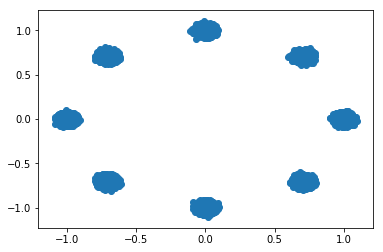

In [12]:
print(len(samples))
print(len(samples[0]))
#print(len(samples[0][0]))
print(samples.T)

x= samples.T[0]
y = samples.T[1]
plt.scatter(x,y)

In [13]:
netG = nn.Sequential()
with netG.name_scope():
    
    #Convolutional
    #initially 128 x 100 x 2
#     netG.add(nn.Conv1DTranspose(50, 4, in_channels = 100, padding = 2, strides =2))
#     netG.add(nn.BatchNorm())
#     netG.add(nn.Activation('relu'))
#     # should now be 128 x 50 x 2
#     netG.add(nn.Conv1DTranspose(25, 4, in_channels = 50, padding = 2, strides =2))
#     netG.add(nn.BatchNorm())
#     netG.add(nn.Activation('relu'))
#     # should still be 128 x 25 x 2
#     netG.add(nn.Conv1DTranspose(5, 4, in_channels = 25, padding = 2, strides =2))
#     netG.add(nn.BatchNorm())
#     netG.add(nn.Activation('relu'))
#     #should still be 128 x 5 x 2
#     netG.add(nn.Conv1DTranspose(2, 4,  in_channels = 5, padding = 2, strides =2))
#     netG.add(nn.BatchNorm())
#     netG.add(nn.Activation('relu'))
#     #should still be 128 x 2 x 2
#     netG.add(nn.Conv1DTranspose(1, 4,  in_channels = 2, padding = 2, strides =2))
#     netG.add(nn.LeakyReLU(0.2))
#     #should still be 128 x 1 x 2
    
    
    #Dense
    #initially 128 x 100 x 2
    netG.add(nn.Dense(1280))
    netG.add(nn.LeakyReLU(0.2))
    netG.add(nn.Dense(640))
    netG.add(nn.LeakyReLU(0.2))
    netG.add(nn.Dense(320))
    #netG.add(nn.LeakyReLU(0.2))
    netG.add(nn.Dense(2))
    
    

In [14]:
netD = nn.Sequential()
with netD.name_scope():
    
    #Convolutional
    #input is 256 x 1 x 2
#     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
#     netD.add(nn.LeakyReLU(0.2))
#     # should still be 256 x 1 x 2
#     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
#     netD.add(nn.BatchNorm())
#     netD.add(nn.LeakyReLU(0.2))
#     # should still be 256 x 1 x 2
#     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
#     netD.add(nn.BatchNorm())
#     netD.add(nn.LeakyReLU(0.2))
#     # should still be 256 x 1 x 2
#     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
#     netD.add(nn.BatchNorm())
#     netD.add(nn.LeakyReLU(0.2))
#     # should still be 256 x 1 x 2
#     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, strides = 2,padding = 2, in_channels = 1))
#     # should still be 256 x 1 x 1


    #Dense
    netD.add(nn.Dense(200))
    #netG.add(nn.LeakyReLU(0.2))
    netD.add(nn.Dense(100))
    netD.add(nn.LeakyReLU(0.2))
    netD.add(nn.Dense(25))
    netD.add(nn.LeakyReLU(0.2))
    netD.add(nn.Dense(1))
    
    
    


In [15]:
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

netG.initialize(mx.init.Normal(0.1), ctx = ctx)
netD.initialize(mx.init.Normal(0.1), ctx = ctx)

trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1':beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1':beta1})
unrolledtrainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1':beta1})


Begin
Done setting up Discriminator
RUNNING


INFO:root:
binary training acc at epoch 0: facc=0.555318
INFO:root:time: 25.788710
INFO:root:time: 25.790977


Epoch: 0
epoch 0
X: 

[2.7077458]
<NDArray 1 @cpu(0)>
Y: 

[4.6487694]
<NDArray 1 @cpu(0)>



[[ 2.7077458   3.0753524 ]
 [ 4.6487694   7.017751  ]
 [ 3.6992695   5.4725866 ]
 [ 4.628221    6.9535685 ]
 [ 5.242441    7.542201  ]
 [ 5.165103    8.005466  ]
 [ 3.3911717   4.795879  ]
 [ 2.579943    3.1062708 ]
 [ 5.0286145   7.172835  ]
 [ 5.5019965   7.960759  ]
 [ 4.170417    5.9318213 ]
 [ 3.3053527   5.300544  ]
 [ 3.0699184   4.399022  ]
 [ 3.6027443   5.314424  ]
 [ 3.8881822   5.235014  ]
 [ 4.0487857   5.514192  ]
 [ 5.7754984   8.835296  ]
 [-0.02548056 -0.9526483 ]
 [ 1.7603465   2.7039495 ]
 [ 4.1340613   5.825949  ]
 [ 4.8135757   6.8993025 ]
 [ 2.9901142   4.025166  ]
 [ 2.2910962   2.8290365 ]
 [ 3.1063008   4.539416  ]
 [ 2.8245287   3.710176  ]
 [ 2.8929782   3.556331  ]
 [ 6.204603    9.231802  ]
 [ 3.1493416   4.7370386 ]
 [ 4.8192773   6.3758774 ]
 [ 4.836994    7.0443883 ]
 [ 4.7403445   7.280397  ]
 [ 3.6269245   5.069134  ]
 [ 3.4547863   5.0070586 ]
 [ 3.9031968   

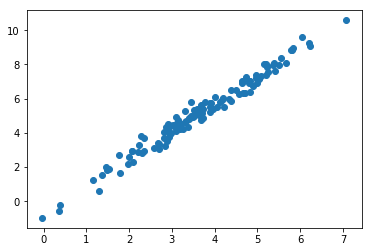

RUNNING
Epoch: 1
RUNNING
Epoch: 2
RUNNING
Epoch: 3
RUNNING
Epoch: 4
RUNNING
Epoch: 5
RUNNING
Epoch: 6
RUNNING
Epoch: 7
RUNNING
Epoch: 8
RUNNING
Epoch: 9
RUNNING
Epoch: 10
RUNNING
Epoch: 11
RUNNING
Epoch: 12
RUNNING
Epoch: 13
RUNNING
Epoch: 14
RUNNING
Epoch: 15
RUNNING
Epoch: 16
RUNNING
Epoch: 17
RUNNING
Epoch: 18
RUNNING
Epoch: 19
RUNNING
Epoch: 20
RUNNING
Epoch: 21
RUNNING
Epoch: 22
RUNNING
Epoch: 23
RUNNING
Epoch: 24
RUNNING
Epoch: 25
RUNNING
Epoch: 26
RUNNING
Epoch: 27
RUNNING
Epoch: 28
RUNNING
Epoch: 29
RUNNING
Epoch: 30
RUNNING
Epoch: 31
RUNNING
Epoch: 32
RUNNING
Epoch: 33
RUNNING
Epoch: 34
RUNNING
Epoch: 35
RUNNING
Epoch: 36
RUNNING
Epoch: 37
RUNNING
Epoch: 38
RUNNING
Epoch: 39
RUNNING
Epoch: 40
RUNNING
Epoch: 41
RUNNING
Epoch: 42
RUNNING
Epoch: 43
RUNNING
Epoch: 44
RUNNING
Epoch: 45
RUNNING
Epoch: 46
RUNNING
Epoch: 47
RUNNING
Epoch: 48
RUNNING
Epoch: 49
RUNNING
Epoch: 50
RUNNING
Epoch: 51
RUNNING
Epoch: 52
RUNNING
Epoch: 53
RUNNING
Epoch: 54
RUNNING
Epoch: 55
RUNNING
Epoch: 56
R

INFO:root:
binary training acc at epoch 100: facc=0.937515
INFO:root:time: 25.360031
INFO:root:time: 25.360497


Epoch: 100
epoch 100
X: 

[-0.66538274]
<NDArray 1 @cpu(0)>
Y: 

[-0.66343373]
<NDArray 1 @cpu(0)>



[[-0.66538274  0.6952854 ]
 [-0.66343373  0.6831205 ]
 [-0.67337227  0.7071366 ]
 [-0.66986763  0.6929987 ]
 [-0.6631299   0.7008641 ]
 [-0.66594064  0.71295017]
 [-0.65755355  0.70846194]
 [-0.67872185  0.7160399 ]
 [-0.66945255  0.7074449 ]
 [-0.66678107  0.7014888 ]
 [-0.6620159   0.72400254]
 [-0.67629904  0.69665915]
 [-0.6612317   0.7078089 ]
 [-0.67791593  0.7387989 ]
 [-0.6690169   0.7077061 ]
 [-0.6534378   0.7054381 ]
 [-0.6698535   0.7183856 ]
 [-0.66590095  0.71081823]
 [-0.66678464  0.7132091 ]
 [-0.66686916  0.70759016]
 [-0.6709132   0.7288908 ]
 [-0.6692815   0.72092915]
 [-0.6687536   0.70680094]
 [-0.6656447   0.69408655]
 [-0.6702314   0.6870442 ]
 [-0.65494925  0.7023733 ]
 [-0.66286004  0.7016897 ]
 [-0.6693847   0.7111518 ]
 [-0.67870814  0.73517793]
 [-0.67005527  0.7034606 ]
 [-0.66188717  0.6897982 ]
 [-0.65700054  0.70621085]
 [-0.6707781   0.71953094]
 [-0.66

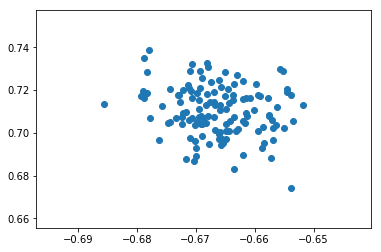

RUNNING
Epoch: 101
RUNNING
Epoch: 102
RUNNING
Epoch: 103
RUNNING
Epoch: 104
RUNNING
Epoch: 105
RUNNING
Epoch: 106
RUNNING
Epoch: 107
RUNNING
Epoch: 108
RUNNING
Epoch: 109
RUNNING
Epoch: 110
RUNNING
Epoch: 111
RUNNING
Epoch: 112
RUNNING
Epoch: 113
RUNNING
Epoch: 114
RUNNING
Epoch: 115
RUNNING
Epoch: 116
RUNNING
Epoch: 117
RUNNING
Epoch: 118
RUNNING
Epoch: 119
RUNNING
Epoch: 120
RUNNING
Epoch: 121
RUNNING
Epoch: 122
RUNNING
Epoch: 123
RUNNING
Epoch: 124
RUNNING
Epoch: 125
RUNNING
Epoch: 126
RUNNING
Epoch: 127
RUNNING
Epoch: 128
RUNNING
Epoch: 129
RUNNING
Epoch: 130
RUNNING
Epoch: 131
RUNNING
Epoch: 132
RUNNING
Epoch: 133
RUNNING
Epoch: 134
RUNNING
Epoch: 135
RUNNING
Epoch: 136
RUNNING
Epoch: 137
RUNNING
Epoch: 138
RUNNING
Epoch: 139
RUNNING
Epoch: 140
RUNNING
Epoch: 141
RUNNING
Epoch: 142
RUNNING
Epoch: 143
RUNNING
Epoch: 144
RUNNING
Epoch: 145
RUNNING
Epoch: 146
RUNNING
Epoch: 147
RUNNING
Epoch: 148
RUNNING
Epoch: 149
RUNNING
Epoch: 150
RUNNING
Epoch: 151
RUNNING
Epoch: 152
RUNNING
Epoc

INFO:root:
binary training acc at epoch 200: facc=0.937477
INFO:root:time: 25.397752
INFO:root:time: 25.398254


Epoch: 200
epoch 200
X: 

[-1.0163071]
<NDArray 1 @cpu(0)>
Y: 

[-0.9991371]
<NDArray 1 @cpu(0)>



[[-1.0163071e+00 -3.1016946e-02]
 [-9.9913710e-01 -1.4515206e-02]
 [-9.8417443e-01 -1.6079694e-03]
 [-9.8747861e-01 -1.5461594e-02]
 [-9.9705344e-01 -2.3766011e-03]
 [-9.9839079e-01 -2.3956403e-02]
 [-9.9976921e-01 -1.5665799e-02]
 [-9.8554045e-01 -1.3724908e-02]
 [-9.8698801e-01  4.8920959e-03]
 [-9.8647732e-01 -1.8814966e-02]
 [-1.0046512e+00  1.0518879e-03]
 [-9.9181902e-01 -2.4593964e-02]
 [-9.8861831e-01 -2.2784248e-02]
 [-1.0086516e+00 -1.8180296e-02]
 [-9.9902880e-01 -1.8220052e-02]
 [-9.7324955e-01 -2.1844730e-02]
 [-9.9392551e-01 -2.1950349e-02]
 [-9.9928284e-01 -1.9953445e-02]
 [-9.9185014e-01  1.4127955e-02]
 [-9.8819309e-01 -2.4815962e-02]
 [-9.8361552e-01 -3.9188206e-02]
 [-9.9850130e-01 -1.5265450e-02]
 [-9.8295951e-01 -2.3927942e-02]
 [-9.8268908e-01 -2.6807860e-02]
 [-9.9557525e-01 -2.7966842e-02]
 [-1.0010270e+00 -1.3996750e-02]
 [-1.0009363e+00 -3.2021180e-02]
 [-9.7719

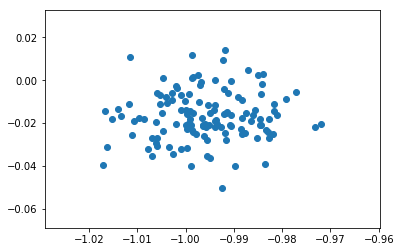

RUNNING
Epoch: 201
RUNNING
Epoch: 202
RUNNING
Epoch: 203
RUNNING
Epoch: 204
RUNNING
Epoch: 205
RUNNING
Epoch: 206
RUNNING
Epoch: 207
RUNNING
Epoch: 208
RUNNING
Epoch: 209
RUNNING
Epoch: 210
RUNNING
Epoch: 211
RUNNING
Epoch: 212
RUNNING
Epoch: 213
RUNNING
Epoch: 214
RUNNING
Epoch: 215
RUNNING
Epoch: 216
RUNNING
Epoch: 217
RUNNING
Epoch: 218
RUNNING
Epoch: 219
RUNNING
Epoch: 220
RUNNING
Epoch: 221
RUNNING
Epoch: 222
RUNNING
Epoch: 223
RUNNING
Epoch: 224
RUNNING
Epoch: 225
RUNNING
Epoch: 226
RUNNING
Epoch: 227
RUNNING
Epoch: 228
RUNNING
Epoch: 229
RUNNING
Epoch: 230
RUNNING
Epoch: 231
RUNNING
Epoch: 232
RUNNING
Epoch: 233
RUNNING
Epoch: 234
RUNNING
Epoch: 235
RUNNING
Epoch: 236
RUNNING
Epoch: 237
RUNNING
Epoch: 238
RUNNING
Epoch: 239
RUNNING
Epoch: 240
RUNNING
Epoch: 241
RUNNING
Epoch: 242
RUNNING
Epoch: 243
RUNNING
Epoch: 244
RUNNING
Epoch: 245
RUNNING
Epoch: 246
RUNNING
Epoch: 247
RUNNING
Epoch: 248
RUNNING
Epoch: 249
RUNNING
Epoch: 250
RUNNING
Epoch: 251
RUNNING
Epoch: 252
RUNNING
Epoc

INFO:root:
binary training acc at epoch 300: facc=0.937515
INFO:root:time: 25.239627
INFO:root:time: 25.242437


Epoch: 300
epoch 300
X: 

[-0.73685]
<NDArray 1 @cpu(0)>
Y: 

[-0.71505415]
<NDArray 1 @cpu(0)>



[[-0.73685     0.7149814 ]
 [-0.71505415  0.7003565 ]
 [-0.70112723  0.6764612 ]
 [-0.7201172   0.7121699 ]
 [-0.70966953  0.6801348 ]
 [-0.7307659   0.69572973]
 [-0.71467847  0.71051   ]
 [-0.7288858   0.7054962 ]
 [-0.70966756  0.6749929 ]
 [-0.7058733   0.69156635]
 [-0.7195584   0.69411767]
 [-0.7315534   0.7161361 ]
 [-0.72195894  0.7043847 ]
 [-0.7218359   0.7063813 ]
 [-0.7238172   0.7014049 ]
 [-0.7275834   0.7109813 ]
 [-0.7391745   0.71450233]
 [-0.7331546   0.71127737]
 [-0.7158463   0.69601166]
 [-0.7357976   0.7107177 ]
 [-0.72097933  0.6943203 ]
 [-0.72905016  0.7032651 ]
 [-0.7098793   0.69207305]
 [-0.7112982   0.684857  ]
 [-0.732895    0.71091837]
 [-0.75553507  0.7263683 ]
 [-0.7035812   0.68200195]
 [-0.73440444  0.7116236 ]
 [-0.7231642   0.70784   ]
 [-0.72240514  0.6999639 ]
 [-0.7187284   0.7012921 ]
 [-0.7111571   0.6930814 ]
 [-0.7131865   0.6964717 ]
 [-0.73362

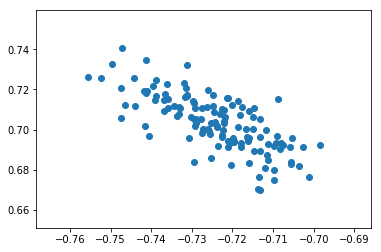

RUNNING
Epoch: 301
RUNNING
Epoch: 302
RUNNING
Epoch: 303
RUNNING
Epoch: 304
RUNNING
Epoch: 305
RUNNING
Epoch: 306
RUNNING
Epoch: 307
RUNNING
Epoch: 308
RUNNING
Epoch: 309
RUNNING
Epoch: 310
RUNNING
Epoch: 311
RUNNING
Epoch: 312
RUNNING
Epoch: 313
RUNNING
Epoch: 314
RUNNING
Epoch: 315
RUNNING
Epoch: 316
RUNNING
Epoch: 317
RUNNING
Epoch: 318
RUNNING
Epoch: 319
RUNNING
Epoch: 320
RUNNING
Epoch: 321
RUNNING
Epoch: 322
RUNNING
Epoch: 323
RUNNING
Epoch: 324
RUNNING
Epoch: 325
RUNNING
Epoch: 326
RUNNING
Epoch: 327
RUNNING
Epoch: 328
RUNNING
Epoch: 329
RUNNING
Epoch: 330
RUNNING
Epoch: 331
RUNNING
Epoch: 332
RUNNING
Epoch: 333
RUNNING
Epoch: 334
RUNNING
Epoch: 335
RUNNING
Epoch: 336
RUNNING
Epoch: 337
RUNNING
Epoch: 338
RUNNING
Epoch: 339
RUNNING
Epoch: 340
RUNNING
Epoch: 341
RUNNING
Epoch: 342
RUNNING
Epoch: 343
RUNNING
Epoch: 344
RUNNING
Epoch: 345
RUNNING
Epoch: 346
RUNNING
Epoch: 347
RUNNING
Epoch: 348
RUNNING
Epoch: 349
RUNNING
Epoch: 350
RUNNING
Epoch: 351
RUNNING
Epoch: 352
RUNNING
Epoc

INFO:root:
binary training acc at epoch 400: facc=0.937481
INFO:root:time: 25.125303
INFO:root:time: 25.127316


Epoch: 400
epoch 400
X: 

[0.0291374]
<NDArray 1 @cpu(0)>
Y: 

[0.03795591]
<NDArray 1 @cpu(0)>



[[0.0291374  1.0108318 ]
 [0.03795591 1.0228053 ]
 [0.03522652 1.0112609 ]
 [0.02570528 1.0038166 ]
 [0.03984326 1.0249364 ]
 [0.01951581 0.99674344]
 [0.02675089 1.0015125 ]
 [0.04518771 1.017566  ]
 [0.0247623  1.0071424 ]
 [0.01603019 1.0050274 ]
 [0.03816882 1.0220823 ]
 [0.0236688  1.0200505 ]
 [0.03369501 1.0027177 ]
 [0.02507263 1.009826  ]
 [0.02436507 0.99705327]
 [0.01534653 0.9915954 ]
 [0.01307529 1.0039675 ]
 [0.0165447  1.0062307 ]
 [0.02760518 1.017367  ]
 [0.01040953 1.0101321 ]
 [0.02781293 1.0070553 ]
 [0.00134361 0.9840535 ]
 [0.02832982 1.0101018 ]
 [0.02917138 1.0176932 ]
 [0.02938309 1.0108719 ]
 [0.02458352 1.0046663 ]
 [0.01997721 1.0091147 ]
 [0.01219365 0.9977598 ]
 [0.02618185 1.0140432 ]
 [0.02063364 1.0145806 ]
 [0.03160727 1.0217228 ]
 [0.01856896 1.0002041 ]
 [0.01766497 0.9995415 ]
 [0.041022   1.0130776 ]
 [0.01774198 0.99008393]
 [0.02085915 1.0049837 ]
 

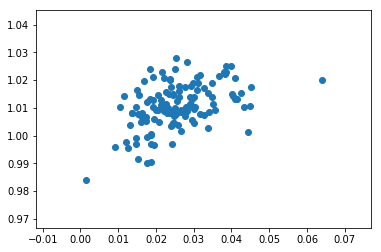

RUNNING
Epoch: 401
RUNNING
Epoch: 402
RUNNING
Epoch: 403
RUNNING
Epoch: 404
RUNNING
Epoch: 405
RUNNING
Epoch: 406
RUNNING
Epoch: 407
RUNNING
Epoch: 408
RUNNING
Epoch: 409
RUNNING
Epoch: 410
RUNNING
Epoch: 411
RUNNING
Epoch: 412
RUNNING
Epoch: 413
RUNNING
Epoch: 414
RUNNING
Epoch: 415
RUNNING
Epoch: 416
RUNNING
Epoch: 417
RUNNING
Epoch: 418
RUNNING
Epoch: 419
RUNNING
Epoch: 420
RUNNING
Epoch: 421
RUNNING
Epoch: 422
RUNNING
Epoch: 423
RUNNING
Epoch: 424
RUNNING
Epoch: 425
RUNNING
Epoch: 426
RUNNING
Epoch: 427
RUNNING
Epoch: 428
RUNNING
Epoch: 429
RUNNING
Epoch: 430
RUNNING
Epoch: 431
RUNNING
Epoch: 432
RUNNING
Epoch: 433
RUNNING
Epoch: 434
RUNNING
Epoch: 435
RUNNING
Epoch: 436
RUNNING
Epoch: 437
RUNNING
Epoch: 438
RUNNING
Epoch: 439
RUNNING
Epoch: 440
RUNNING
Epoch: 441
RUNNING
Epoch: 442
RUNNING
Epoch: 443
RUNNING
Epoch: 444
RUNNING
Epoch: 445
RUNNING
Epoch: 446
RUNNING
Epoch: 447
RUNNING
Epoch: 448
RUNNING
Epoch: 449
RUNNING
Epoch: 450
RUNNING
Epoch: 451
RUNNING
Epoch: 452
RUNNING
Epoc

INFO:root:
binary training acc at epoch 500: facc=0.875004
INFO:root:time: 25.118504
INFO:root:time: 25.121678


Epoch: 500
epoch 500
X: 

[0.6919084]
<NDArray 1 @cpu(0)>
Y: 

[-0.00078139]
<NDArray 1 @cpu(0)>



[[ 6.9190842e-01  7.1317428e-01]
 [-7.8138709e-04  1.0023289e+00]
 [ 7.1667427e-01  6.8982297e-01]
 [ 7.0804113e-01  7.0220274e-01]
 [ 6.0710132e-02  9.7607923e-01]
 [ 6.8596423e-01  7.0892549e-01]
 [ 2.9008031e-02  1.0055344e+00]
 [-2.4649426e-02  9.8243725e-01]
 [ 7.1400768e-01  6.9281667e-01]
 [ 7.1005052e-01  6.9970512e-01]
 [ 6.7365855e-01  7.2305554e-01]
 [ 4.0109754e-03  9.9863738e-01]
 [ 2.0301327e-02  1.0197684e+00]
 [ 7.1951032e-02  9.9636340e-01]
 [-2.6214018e-02  1.0000100e+00]
 [ 6.7190403e-01  7.1413451e-01]
 [ 3.8979232e-02  9.6754307e-01]
 [ 6.7259306e-01  6.9213814e-01]
 [ 6.9312572e-01  6.7748284e-01]
 [-1.6134977e-02  9.9089164e-01]
 [ 7.0201075e-01  7.0993388e-01]
 [ 7.2011095e-01  7.0317590e-01]
 [ 4.9813747e-02  9.9079746e-01]
 [ 7.3585790e-01  6.7730498e-01]
 [ 6.7313772e-01  7.1366006e-01]
 [ 6.7579168e-01  7.0492411e-01]
 [ 6.6409206e-01  7.0332050e-01]
 [ 2.9128

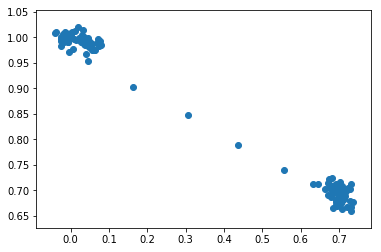

RUNNING
Epoch: 501
RUNNING
Epoch: 502
RUNNING
Epoch: 503
RUNNING
Epoch: 504
RUNNING
Epoch: 505
RUNNING
Epoch: 506
RUNNING
Epoch: 507
RUNNING
Epoch: 508
RUNNING
Epoch: 509
RUNNING
Epoch: 510
RUNNING
Epoch: 511
RUNNING
Epoch: 512
RUNNING
Epoch: 513
RUNNING
Epoch: 514
RUNNING
Epoch: 515
RUNNING
Epoch: 516
RUNNING
Epoch: 517
RUNNING
Epoch: 518
RUNNING
Epoch: 519
RUNNING
Epoch: 520
RUNNING
Epoch: 521
RUNNING
Epoch: 522
RUNNING
Epoch: 523
RUNNING
Epoch: 524
RUNNING
Epoch: 525
RUNNING
Epoch: 526
RUNNING
Epoch: 527
RUNNING
Epoch: 528
RUNNING
Epoch: 529
RUNNING
Epoch: 530
RUNNING
Epoch: 531
RUNNING
Epoch: 532
RUNNING
Epoch: 533
RUNNING
Epoch: 534
RUNNING
Epoch: 535
RUNNING
Epoch: 536
RUNNING
Epoch: 537
RUNNING
Epoch: 538
RUNNING
Epoch: 539
RUNNING
Epoch: 540
RUNNING
Epoch: 541
RUNNING
Epoch: 542
RUNNING
Epoch: 543
RUNNING
Epoch: 544
RUNNING
Epoch: 545
RUNNING
Epoch: 546
RUNNING
Epoch: 547
RUNNING
Epoch: 548
RUNNING
Epoch: 549
RUNNING
Epoch: 550
RUNNING
Epoch: 551
RUNNING
Epoch: 552
RUNNING
Epoc

INFO:root:
binary training acc at epoch 600: facc=0.875004
INFO:root:time: 25.154491
INFO:root:time: 25.156531


Epoch: 600
epoch 600
X: 

[0.6915717]
<NDArray 1 @cpu(0)>
Y: 

[0.06681368]
<NDArray 1 @cpu(0)>



[[ 6.9157171e-01  7.1609306e-01]
 [ 6.6813678e-02  9.8257810e-01]
 [-2.0856626e-02  1.0350412e+00]
 [ 5.0063133e-03  1.0083618e+00]
 [-8.8676810e-05  9.8912048e-01]
 [ 7.2196722e-03  1.0415066e+00]
 [ 7.2266942e-01  7.1475375e-01]
 [ 5.7409257e-03  1.0166550e+00]
 [ 6.9672573e-01  7.3885518e-01]
 [ 1.8453509e-02  1.0071136e+00]
 [ 7.0722604e-01  7.1620858e-01]
 [ 1.1941358e-02  1.0241816e+00]
 [ 8.0811530e-03  1.0075873e+00]
 [ 7.0735961e-01  7.2739327e-01]
 [-7.5613111e-03  1.0010265e+00]
 [-4.1880310e-03  1.0197458e+00]
 [ 6.9943321e-01  7.3923939e-01]
 [ 7.2338492e-01  7.0449489e-01]
 [ 7.4384350e-01  7.4168551e-01]
 [ 7.1287352e-01  7.2845513e-01]
 [ 7.1852064e-01  7.1403146e-01]
 [ 1.0213017e-02  1.0145059e+00]
 [ 7.3161370e-01  7.3070419e-01]
 [-3.2646775e-02  1.0085757e+00]
 [ 2.1390721e-02  1.0400786e+00]
 [ 6.9605100e-01  7.2146910e-01]
 [ 6.9922113e-01  7.2437555e-01]
 [ 2.28191

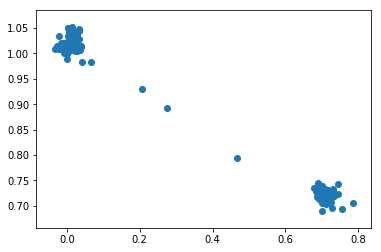

RUNNING
Epoch: 601
RUNNING
Epoch: 602
RUNNING
Epoch: 603
RUNNING
Epoch: 604
RUNNING
Epoch: 605
RUNNING
Epoch: 606
RUNNING
Epoch: 607
RUNNING
Epoch: 608
RUNNING
Epoch: 609
RUNNING
Epoch: 610
RUNNING
Epoch: 611
RUNNING
Epoch: 612
RUNNING
Epoch: 613
RUNNING
Epoch: 614
RUNNING
Epoch: 615
RUNNING
Epoch: 616
RUNNING
Epoch: 617
RUNNING
Epoch: 618
RUNNING
Epoch: 619
RUNNING
Epoch: 620
RUNNING
Epoch: 621
RUNNING
Epoch: 622
RUNNING
Epoch: 623
RUNNING
Epoch: 624
RUNNING
Epoch: 625
RUNNING
Epoch: 626
RUNNING
Epoch: 627
RUNNING
Epoch: 628
RUNNING
Epoch: 629
RUNNING
Epoch: 630
RUNNING
Epoch: 631
RUNNING
Epoch: 632
RUNNING
Epoch: 633
RUNNING
Epoch: 634
RUNNING
Epoch: 635
RUNNING
Epoch: 636
RUNNING
Epoch: 637
RUNNING
Epoch: 638
RUNNING
Epoch: 639
RUNNING
Epoch: 640
RUNNING
Epoch: 641
RUNNING
Epoch: 642
RUNNING
Epoch: 643
RUNNING
Epoch: 644
RUNNING
Epoch: 645
RUNNING
Epoch: 646
RUNNING
Epoch: 647
RUNNING
Epoch: 648
RUNNING
Epoch: 649
RUNNING
Epoch: 650
RUNNING
Epoch: 651
RUNNING
Epoch: 652
RUNNING
Epoc

INFO:root:
binary training acc at epoch 700: facc=0.874889
INFO:root:time: 25.315571
INFO:root:time: 25.317753


Epoch: 700
epoch 700
X: 

[-0.04004179]
<NDArray 1 @cpu(0)>
Y: 

[-0.02489534]
<NDArray 1 @cpu(0)>



[[-0.04004179  0.974247  ]
 [-0.02489534  0.9689363 ]
 [-0.00960666  0.9575676 ]
 [-0.02254248  0.9610024 ]
 [-0.01008298  0.94021463]
 [-0.00342469  0.9630875 ]
 [ 0.70509934  0.741245  ]
 [ 0.00707047  0.95473236]
 [ 0.71042126  0.70738846]
 [ 0.71439415  0.7394868 ]
 [-0.03469845  0.9769802 ]
 [-0.0284903   0.9419869 ]
 [ 0.71079993  0.75221676]
 [-0.0025816   0.9421158 ]
 [-0.01827646  0.9458454 ]
 [ 0.70029175  0.7624021 ]
 [-0.01789621  0.9622853 ]
 [ 0.70239717  0.74900246]
 [ 0.72351736  0.73025674]
 [-0.0225424   0.9513649 ]
 [-0.03752735  0.9890791 ]
 [ 0.6981656   0.741843  ]
 [ 0.74423784  0.7155013 ]
 [ 0.70184773  0.7646875 ]
 [ 0.7227092   0.6851605 ]
 [-0.01950574  0.9533303 ]
 [ 0.00311697  0.94066024]
 [-0.03949723  0.97388196]
 [-0.0068588   0.9728607 ]
 [-0.01069526  0.9667865 ]
 [-0.01517104  0.9494445 ]
 [ 0.70471317  0.74697614]
 [ 0.7169388   0.7380987 ]
 [ 0.00

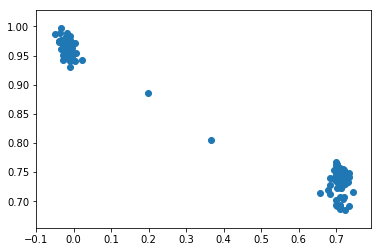

RUNNING
Epoch: 701
RUNNING
Epoch: 702
RUNNING
Epoch: 703
RUNNING
Epoch: 704
RUNNING
Epoch: 705
RUNNING
Epoch: 706
RUNNING
Epoch: 707
RUNNING
Epoch: 708
RUNNING
Epoch: 709
RUNNING
Epoch: 710
RUNNING
Epoch: 711
RUNNING
Epoch: 712
RUNNING
Epoch: 713
RUNNING
Epoch: 714
RUNNING
Epoch: 715
RUNNING
Epoch: 716
RUNNING
Epoch: 717
RUNNING
Epoch: 718
RUNNING
Epoch: 719
RUNNING
Epoch: 720
RUNNING
Epoch: 721
RUNNING
Epoch: 722
RUNNING
Epoch: 723
RUNNING
Epoch: 724
RUNNING
Epoch: 725
RUNNING
Epoch: 726
RUNNING
Epoch: 727
RUNNING
Epoch: 728
RUNNING
Epoch: 729
RUNNING
Epoch: 730
RUNNING
Epoch: 731
RUNNING
Epoch: 732
RUNNING
Epoch: 733
RUNNING
Epoch: 734
RUNNING
Epoch: 735
RUNNING
Epoch: 736
RUNNING
Epoch: 737
RUNNING
Epoch: 738
RUNNING
Epoch: 739
RUNNING
Epoch: 740
RUNNING
Epoch: 741
RUNNING
Epoch: 742
RUNNING
Epoch: 743
RUNNING
Epoch: 744
RUNNING
Epoch: 745
RUNNING
Epoch: 746
RUNNING
Epoch: 747
RUNNING
Epoch: 748
RUNNING
Epoch: 749
RUNNING
Epoch: 750
RUNNING
Epoch: 751
RUNNING
Epoch: 752
RUNNING
Epoc

INFO:root:
binary training acc at epoch 800: facc=0.875004
INFO:root:time: 25.129967
INFO:root:time: 25.132485


Epoch: 800
epoch 800
X: 

[0.70169693]
<NDArray 1 @cpu(0)>
Y: 

[0.7148321]
<NDArray 1 @cpu(0)>



[[ 7.0169693e-01  6.9030148e-01]
 [ 7.1483213e-01  6.8977320e-01]
 [ 7.0776719e-01  6.7863756e-01]
 [ 3.9031424e-02  9.9603808e-01]
 [ 7.3008204e-01  6.7292839e-01]
 [ 3.0667281e-02  9.9961030e-01]
 [ 1.3943108e-02  1.0063338e+00]
 [ 6.8812227e-01  6.8022895e-01]
 [ 2.2078576e-03  1.0158279e+00]
 [ 7.0433557e-01  6.9894391e-01]
 [ 6.8764168e-01  7.0764828e-01]
 [ 7.0569217e-01  6.9559819e-01]
 [ 1.6742613e-02  1.0038142e+00]
 [ 5.9643596e-01  7.4332297e-01]
 [ 6.9313776e-01  6.9335753e-01]
 [ 4.2865232e-02  9.8931479e-01]
 [ 6.8453789e-01  6.9009417e-01]
 [ 1.2688277e-02  1.0138364e+00]
 [ 8.1430189e-06  1.0147617e+00]
 [ 9.5396079e-03  1.0113059e+00]
 [ 3.3438742e-02  9.9347734e-01]
 [ 6.8769896e-01  6.8859673e-01]
 [ 6.8752265e-01  6.8439245e-01]
 [ 2.3972822e-02  1.0085963e+00]
 [ 3.3930871e-01  8.3789808e-01]
 [ 7.0452106e-01  6.9316679e-01]
 [ 2.9294061e-02  1.0051457e+00]
 [ 7.11464

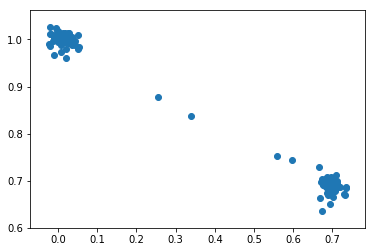

RUNNING
Epoch: 801
RUNNING
Epoch: 802
RUNNING
Epoch: 803
RUNNING
Epoch: 804
RUNNING
Epoch: 805
RUNNING
Epoch: 806
RUNNING
Epoch: 807
RUNNING
Epoch: 808
RUNNING
Epoch: 809
RUNNING
Epoch: 810
RUNNING
Epoch: 811
RUNNING
Epoch: 812
RUNNING
Epoch: 813
RUNNING
Epoch: 814
RUNNING
Epoch: 815
RUNNING
Epoch: 816
RUNNING
Epoch: 817
RUNNING
Epoch: 818
RUNNING
Epoch: 819
RUNNING
Epoch: 820
RUNNING
Epoch: 821
RUNNING
Epoch: 822
RUNNING
Epoch: 823
RUNNING
Epoch: 824
RUNNING
Epoch: 825
RUNNING
Epoch: 826
RUNNING
Epoch: 827
RUNNING
Epoch: 828
RUNNING
Epoch: 829
RUNNING
Epoch: 830
RUNNING
Epoch: 831
RUNNING
Epoch: 832
RUNNING
Epoch: 833
RUNNING
Epoch: 834
RUNNING
Epoch: 835
RUNNING
Epoch: 836
RUNNING
Epoch: 837
RUNNING
Epoch: 838
RUNNING
Epoch: 839
RUNNING
Epoch: 840
RUNNING
Epoch: 841
RUNNING
Epoch: 842
RUNNING
Epoch: 843
RUNNING
Epoch: 844
RUNNING
Epoch: 845
RUNNING
Epoch: 846
RUNNING
Epoch: 847
RUNNING
Epoch: 848
RUNNING
Epoch: 849
RUNNING
Epoch: 850
RUNNING
Epoch: 851
RUNNING
Epoch: 852
RUNNING
Epoc

INFO:root:
binary training acc at epoch 900: facc=0.875004
INFO:root:time: 25.136821
INFO:root:time: 25.138880


Epoch: 900
epoch 900
X: 

[0.7219808]
<NDArray 1 @cpu(0)>
Y: 

[0.6976902]
<NDArray 1 @cpu(0)>



[[0.7219808  0.7390914 ]
 [0.6976902  0.73841393]
 [0.69795394 0.73038995]
 [0.04493781 1.0055072 ]
 [0.04153768 1.0096008 ]
 [0.62500936 0.77586913]
 [0.03295195 1.0076549 ]
 [0.71628857 0.7326948 ]
 [0.03052044 0.9802402 ]
 [0.71863943 0.7300494 ]
 [0.03708621 1.0058928 ]
 [0.02368017 1.0210147 ]
 [0.69644916 0.737057  ]
 [0.05250684 0.98485494]
 [0.04138806 0.991997  ]
 [0.70565474 0.7324616 ]
 [0.7246965  0.72587734]
 [0.04927719 0.97105074]
 [0.04623237 0.9566897 ]
 [0.05096691 0.99433136]
 [0.69302136 0.726207  ]
 [0.02427557 1.0181078 ]
 [0.03383189 0.99921155]
 [0.7159203  0.7249948 ]
 [0.03607919 1.0008979 ]
 [0.68643564 0.7381806 ]
 [0.02680271 1.0136855 ]
 [0.05764251 0.9998386 ]
 [0.71107966 0.7327083 ]
 [0.70452654 0.73465216]
 [0.03911462 1.0108789 ]
 [0.72294235 0.7295896 ]
 [0.0668049  0.9987159 ]
 [0.71882075 0.73279214]
 [0.72171074 0.735753  ]
 [0.6973598  0.7329226 ]
 [

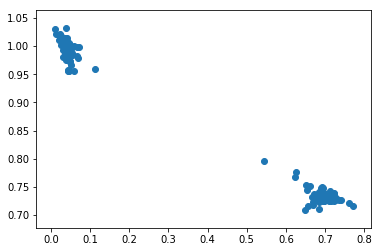

RUNNING
Epoch: 901
RUNNING
Epoch: 902
RUNNING
Epoch: 903
RUNNING
Epoch: 904
RUNNING
Epoch: 905
RUNNING
Epoch: 906
RUNNING
Epoch: 907
RUNNING
Epoch: 908
RUNNING
Epoch: 909
RUNNING
Epoch: 910
RUNNING
Epoch: 911
RUNNING
Epoch: 912
RUNNING
Epoch: 913
RUNNING
Epoch: 914
RUNNING
Epoch: 915
RUNNING
Epoch: 916
RUNNING
Epoch: 917
RUNNING
Epoch: 918
RUNNING
Epoch: 919
RUNNING
Epoch: 920
RUNNING
Epoch: 921
RUNNING
Epoch: 922
RUNNING
Epoch: 923
RUNNING
Epoch: 924
RUNNING
Epoch: 925
RUNNING
Epoch: 926
RUNNING
Epoch: 927
RUNNING
Epoch: 928
RUNNING
Epoch: 929
RUNNING
Epoch: 930
RUNNING
Epoch: 931
RUNNING
Epoch: 932
RUNNING
Epoch: 933
RUNNING
Epoch: 934
RUNNING
Epoch: 935
RUNNING
Epoch: 936
RUNNING
Epoch: 937
RUNNING
Epoch: 938
RUNNING
Epoch: 939
RUNNING
Epoch: 940
RUNNING
Epoch: 941
RUNNING
Epoch: 942
RUNNING
Epoch: 943
RUNNING
Epoch: 944
RUNNING
Epoch: 945
RUNNING
Epoch: 946
RUNNING
Epoch: 947
RUNNING
Epoch: 948
RUNNING
Epoch: 949
RUNNING
Epoch: 950
RUNNING
Epoch: 951
RUNNING
Epoch: 952
RUNNING
Epoc

INFO:root:
binary training acc at epoch 1000: facc=0.874721
INFO:root:time: 25.082252
INFO:root:time: 25.082879


Epoch: 1000
epoch 1000
X: 

[1.0045502]
<NDArray 1 @cpu(0)>
Y: 

[0.7183091]
<NDArray 1 @cpu(0)>



[[ 1.00455022e+00  5.91969490e-03]
 [ 7.18309104e-01  7.26743281e-01]
 [ 1.00398815e+00  1.28527284e-02]
 [ 1.00571728e+00  9.88286734e-03]
 [ 7.30378151e-01  6.82838202e-01]
 [ 7.44025469e-01  6.71274304e-01]
 [ 1.00281549e+00 -2.33089924e-03]
 [ 7.39658833e-01  6.94762886e-01]
 [ 1.00914478e+00  1.37539506e-02]
 [ 9.89317179e-01  8.63194466e-04]
 [ 6.86534405e-01  7.21595109e-01]
 [ 1.00642216e+00  1.05500221e-05]
 [ 1.00382066e+00 -7.30156898e-04]
 [ 7.25649476e-01  6.83091640e-01]
 [ 7.37735868e-01  6.95729733e-01]
 [ 7.37510622e-01  6.99045718e-01]
 [ 9.99186993e-01  1.04627013e-02]
 [ 1.04416931e+00 -2.00931430e-02]
 [ 6.85039103e-01  7.23433912e-01]
 [ 1.01144803e+00  3.22555304e-02]
 [ 7.35627711e-01  6.85281277e-01]
 [ 7.16574609e-01  7.08732843e-01]
 [ 1.01192641e+00  3.56912613e-04]
 [ 6.81638300e-01  7.24814296e-01]
 [ 7.29719937e-01  7.15313792e-01]
 [ 7.35731602e-01  6.6296

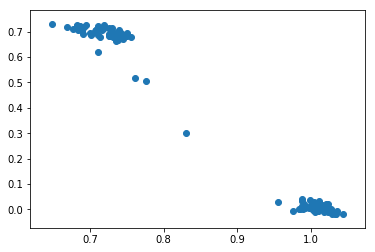

RUNNING
Epoch: 1001
RUNNING
Epoch: 1002
RUNNING
Epoch: 1003
RUNNING
Epoch: 1004
RUNNING
Epoch: 1005
RUNNING
Epoch: 1006
RUNNING
Epoch: 1007
RUNNING
Epoch: 1008
RUNNING
Epoch: 1009
RUNNING
Epoch: 1010
RUNNING
Epoch: 1011
RUNNING
Epoch: 1012
RUNNING
Epoch: 1013
RUNNING
Epoch: 1014
RUNNING
Epoch: 1015
RUNNING
Epoch: 1016
RUNNING
Epoch: 1017
RUNNING
Epoch: 1018
RUNNING
Epoch: 1019
RUNNING
Epoch: 1020
RUNNING
Epoch: 1021
RUNNING
Epoch: 1022
RUNNING
Epoch: 1023
RUNNING
Epoch: 1024
RUNNING
Epoch: 1025
RUNNING
Epoch: 1026
RUNNING
Epoch: 1027
RUNNING
Epoch: 1028
RUNNING
Epoch: 1029
RUNNING
Epoch: 1030
RUNNING
Epoch: 1031
RUNNING
Epoch: 1032
RUNNING
Epoch: 1033
RUNNING
Epoch: 1034
RUNNING
Epoch: 1035
RUNNING
Epoch: 1036
RUNNING
Epoch: 1037
RUNNING
Epoch: 1038
RUNNING
Epoch: 1039
RUNNING
Epoch: 1040
RUNNING
Epoch: 1041
RUNNING
Epoch: 1042
RUNNING
Epoch: 1043
RUNNING
Epoch: 1044
RUNNING
Epoch: 1045
RUNNING
Epoch: 1046
RUNNING
Epoch: 1047
RUNNING
Epoch: 1048
RUNNING
Epoch: 1049
RUNNING
Epoch: 1050


INFO:root:
binary training acc at epoch 1100: facc=0.937523
INFO:root:time: 25.238680
INFO:root:time: 25.240940


Epoch: 1100
epoch 1100
X: 

[0.73043406]
<NDArray 1 @cpu(0)>
Y: 

[0.7215817]
<NDArray 1 @cpu(0)>



[[0.73043406 0.67109466]
 [0.7215817  0.6800331 ]
 [0.72333705 0.6746429 ]
 [0.70879054 0.6713964 ]
 [0.71422744 0.6833369 ]
 [0.71871585 0.67083967]
 [0.70783025 0.6928872 ]
 [0.7252201  0.6492366 ]
 [0.72881293 0.67686605]
 [0.73052365 0.6468513 ]
 [0.6963072  0.66189045]
 [0.73141855 0.6629569 ]
 [0.72226113 0.668357  ]
 [0.7247869  0.67063004]
 [0.70129704 0.66882783]
 [0.7186377  0.67049205]
 [0.7099292  0.67196894]
 [0.73613584 0.6690172 ]
 [0.72010976 0.67647004]
 [0.727199   0.64893126]
 [0.7236092  0.6651168 ]
 [0.7403455  0.683815  ]
 [0.7268063  0.67930925]
 [0.70970154 0.6733172 ]
 [0.6951833  0.6932047 ]
 [0.70659035 0.6707257 ]
 [0.7202861  0.6790544 ]
 [0.7249248  0.6450813 ]
 [0.7173685  0.6836053 ]
 [0.6938113  0.711372  ]
 [0.7174087  0.6539896 ]
 [0.7084375  0.67701507]
 [0.680297   0.67477363]
 [0.7262011  0.6736707 ]
 [0.7262272  0.67172956]
 [0.7192389  0.675599  ]

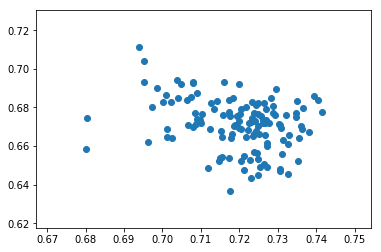

RUNNING
Epoch: 1101
RUNNING
Epoch: 1102
RUNNING
Epoch: 1103
RUNNING
Epoch: 1104
RUNNING
Epoch: 1105
RUNNING
Epoch: 1106
RUNNING
Epoch: 1107
RUNNING
Epoch: 1108
RUNNING
Epoch: 1109
RUNNING
Epoch: 1110
RUNNING
Epoch: 1111
RUNNING
Epoch: 1112
RUNNING
Epoch: 1113
RUNNING
Epoch: 1114
RUNNING
Epoch: 1115
RUNNING
Epoch: 1116
RUNNING
Epoch: 1117
RUNNING
Epoch: 1118
RUNNING
Epoch: 1119
RUNNING
Epoch: 1120
RUNNING
Epoch: 1121
RUNNING
Epoch: 1122
RUNNING
Epoch: 1123
RUNNING
Epoch: 1124
RUNNING
Epoch: 1125
RUNNING
Epoch: 1126
RUNNING
Epoch: 1127
RUNNING
Epoch: 1128
RUNNING
Epoch: 1129
RUNNING
Epoch: 1130
RUNNING
Epoch: 1131
RUNNING
Epoch: 1132
RUNNING
Epoch: 1133
RUNNING
Epoch: 1134
RUNNING
Epoch: 1135
RUNNING
Epoch: 1136
RUNNING
Epoch: 1137
RUNNING
Epoch: 1138
RUNNING
Epoch: 1139
RUNNING
Epoch: 1140
RUNNING
Epoch: 1141
RUNNING
Epoch: 1142
RUNNING
Epoch: 1143
RUNNING
Epoch: 1144
RUNNING
Epoch: 1145
RUNNING
Epoch: 1146
RUNNING
Epoch: 1147
RUNNING
Epoch: 1148
RUNNING
Epoch: 1149
RUNNING
Epoch: 1150


INFO:root:
binary training acc at epoch 1200: facc=0.875004
INFO:root:time: 25.129553
INFO:root:time: 25.130116


Epoch: 1200
epoch 1200
X: 

[0.0244422]
<NDArray 1 @cpu(0)>
Y: 

[0.68543303]
<NDArray 1 @cpu(0)>



[[ 2.44421959e-02  1.00545192e+00]
 [ 6.85433030e-01  7.37791359e-01]
 [ 1.05675757e-02  1.03469193e+00]
 [ 6.70247793e-01  7.36378372e-01]
 [ 9.29027796e-04  1.02687359e+00]
 [-8.54456425e-03  1.00951076e+00]
 [ 1.20973587e-02  1.02261329e+00]
 [ 8.64475965e-04  1.07287598e+00]
 [ 6.92512155e-01  7.12414980e-01]
 [ 2.50855088e-03  1.03398323e+00]
 [ 2.49891579e-02  9.84446049e-01]
 [ 7.40102649e-01  6.91316903e-01]
 [ 1.73866153e-02  9.97670054e-01]
 [ 7.27865458e-01  7.11024642e-01]
 [-2.35820413e-02  1.06128216e+00]
 [-3.11429501e-02  1.09638071e+00]
 [ 7.15643167e-01  7.03043878e-01]
 [ 7.11993694e-01  6.80969715e-01]
 [ 6.99147224e-01  7.02130735e-01]
 [ 7.31814086e-01  6.97193384e-01]
 [ 6.95444345e-01  6.96643531e-01]
 [ 7.13251591e-01  6.77909732e-01]
 [ 1.89687908e-02  9.95187283e-01]
 [ 7.23754168e-01  6.61115646e-01]
 [ 7.15300441e-01  7.08767414e-01]
 [ 2.92807519e-02  9.947

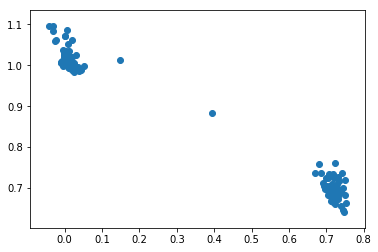

RUNNING
Epoch: 1201
RUNNING
Epoch: 1202
RUNNING
Epoch: 1203
RUNNING
Epoch: 1204
RUNNING
Epoch: 1205
RUNNING
Epoch: 1206
RUNNING
Epoch: 1207
RUNNING
Epoch: 1208
RUNNING
Epoch: 1209
RUNNING
Epoch: 1210
RUNNING
Epoch: 1211
RUNNING
Epoch: 1212
RUNNING
Epoch: 1213
RUNNING
Epoch: 1214
RUNNING
Epoch: 1215
RUNNING
Epoch: 1216
RUNNING
Epoch: 1217
RUNNING
Epoch: 1218
RUNNING
Epoch: 1219
RUNNING
Epoch: 1220
RUNNING
Epoch: 1221
RUNNING
Epoch: 1222
RUNNING
Epoch: 1223
RUNNING
Epoch: 1224
RUNNING
Epoch: 1225
RUNNING
Epoch: 1226
RUNNING
Epoch: 1227
RUNNING
Epoch: 1228
RUNNING
Epoch: 1229
RUNNING
Epoch: 1230
RUNNING
Epoch: 1231
RUNNING
Epoch: 1232
RUNNING
Epoch: 1233
RUNNING
Epoch: 1234
RUNNING
Epoch: 1235
RUNNING
Epoch: 1236
RUNNING
Epoch: 1237
RUNNING
Epoch: 1238
RUNNING
Epoch: 1239
RUNNING
Epoch: 1240
RUNNING
Epoch: 1241
RUNNING
Epoch: 1242
RUNNING
Epoch: 1243
RUNNING
Epoch: 1244
RUNNING
Epoch: 1245
RUNNING
Epoch: 1246
RUNNING
Epoch: 1247
RUNNING
Epoch: 1248
RUNNING
Epoch: 1249
RUNNING
Epoch: 1250


INFO:root:
binary training acc at epoch 1300: facc=0.875004
INFO:root:time: 25.024708
INFO:root:time: 25.027752


Epoch: 1300
epoch 1300
X: 

[0.72381616]
<NDArray 1 @cpu(0)>
Y: 

[0.01547027]
<NDArray 1 @cpu(0)>



[[ 7.2381616e-01  7.2463399e-01]
 [ 1.5470266e-02  1.0123394e+00]
 [ 2.0725250e-02  1.0160267e+00]
 [ 7.3882461e-01  7.3719782e-01]
 [ 7.3661184e-01  7.4598360e-01]
 [ 2.6275486e-02  1.0112548e+00]
 [-9.0812147e-03  1.0130539e+00]
 [ 6.9143808e-01  7.2741938e-01]
 [ 7.4394494e-01  7.0885694e-01]
 [ 6.9019508e-01  7.2560769e-01]
 [ 6.9880694e-01  7.3052180e-01]
 [ 7.1375763e-01  7.4472684e-01]
 [ 7.1514916e-01  7.2492421e-01]
 [ 6.8503630e-01  7.3656929e-01]
 [ 7.1187818e-01  7.2794598e-01]
 [ 9.9324584e-03  1.0391719e+00]
 [ 7.4226588e-01  7.0368588e-01]
 [ 4.0123403e-02  1.0226111e+00]
 [ 5.2060217e-02  1.0139732e+00]
 [ 8.0164343e-02  1.0102694e+00]
 [ 7.2840852e-01  7.1628183e-01]
 [ 7.0741987e-01  7.2531694e-01]
 [ 7.3374271e-01  7.0993274e-01]
 [-4.1833520e-04  1.0107307e+00]
 [ 6.6634148e-01  7.3839426e-01]
 [ 7.2623521e-01  7.1874249e-01]
 [ 2.5360793e-02  1.0037785e+00]
 [ 7.07

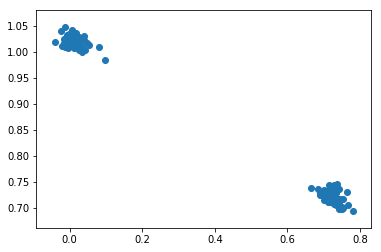

RUNNING
Epoch: 1301
RUNNING
Epoch: 1302
RUNNING
Epoch: 1303
RUNNING
Epoch: 1304
RUNNING
Epoch: 1305
RUNNING
Epoch: 1306
RUNNING
Epoch: 1307
RUNNING
Epoch: 1308
RUNNING
Epoch: 1309
RUNNING
Epoch: 1310
RUNNING
Epoch: 1311
RUNNING
Epoch: 1312
RUNNING
Epoch: 1313
RUNNING
Epoch: 1314
RUNNING
Epoch: 1315
RUNNING
Epoch: 1316
RUNNING
Epoch: 1317
RUNNING
Epoch: 1318
RUNNING
Epoch: 1319
RUNNING
Epoch: 1320
RUNNING
Epoch: 1321
RUNNING
Epoch: 1322
RUNNING
Epoch: 1323
RUNNING
Epoch: 1324
RUNNING
Epoch: 1325
RUNNING
Epoch: 1326
RUNNING
Epoch: 1327
RUNNING
Epoch: 1328
RUNNING
Epoch: 1329
RUNNING
Epoch: 1330
RUNNING
Epoch: 1331
RUNNING
Epoch: 1332
RUNNING
Epoch: 1333
RUNNING
Epoch: 1334
RUNNING
Epoch: 1335
RUNNING
Epoch: 1336
RUNNING
Epoch: 1337
RUNNING
Epoch: 1338
RUNNING
Epoch: 1339
RUNNING
Epoch: 1340
RUNNING
Epoch: 1341
RUNNING
Epoch: 1342
RUNNING
Epoch: 1343
RUNNING
Epoch: 1344
RUNNING
Epoch: 1345
RUNNING
Epoch: 1346
RUNNING
Epoch: 1347
RUNNING
Epoch: 1348
RUNNING
Epoch: 1349
RUNNING
Epoch: 1350


INFO:root:
binary training acc at epoch 1400: facc=0.874847
INFO:root:time: 25.144428
INFO:root:time: 25.145455


Epoch: 1400
epoch 1400
X: 

[0.74851996]
<NDArray 1 @cpu(0)>
Y: 

[0.00196084]
<NDArray 1 @cpu(0)>



[[ 7.4851996e-01  6.8308866e-01]
 [ 1.9608438e-03  1.0201095e+00]
 [ 6.9640398e-01  7.1101928e-01]
 [-2.7047485e-02  1.0336332e+00]
 [-4.2925179e-03  1.0350564e+00]
 [-1.9046664e-02  1.0365558e+00]
 [ 2.5866032e-03  1.0163102e+00]
 [-3.2926798e-03  1.0300145e+00]
 [ 7.2706622e-01  7.0473409e-01]
 [ 2.1480381e-02  1.0145804e+00]
 [ 1.4008105e-02  1.0248426e+00]
 [ 7.5053358e-01  6.7866373e-01]
 [ 7.2338319e-01  6.9460303e-01]
 [ 5.7321191e-03  1.0254042e+00]
 [-2.3342043e-02  1.0361001e+00]
 [-1.8418133e-03  1.0156132e+00]
 [ 6.4584738e-01  7.5471294e-01]
 [-3.1567752e-02  1.0399815e+00]
 [ 7.5250745e-01  6.7966223e-01]
 [ 7.5973499e-01  6.7148602e-01]
 [ 7.3634243e-01  6.9824147e-01]
 [ 7.3716605e-01  6.8138665e-01]
 [ 7.2827661e-01  6.8824500e-01]
 [ 7.1347857e-01  7.1621627e-01]
 [-4.2147160e-02  1.0289865e+00]
 [-1.5871882e-02  1.0348480e+00]
 [-1.1187285e-02  1.0261834e+00]
 [ 2.70

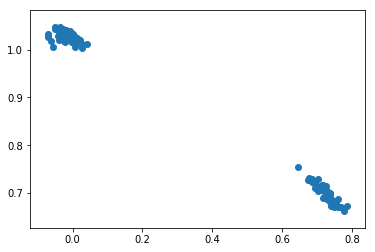

RUNNING
Epoch: 1401
RUNNING
Epoch: 1402
RUNNING
Epoch: 1403
RUNNING
Epoch: 1404
RUNNING
Epoch: 1405
RUNNING
Epoch: 1406
RUNNING
Epoch: 1407
RUNNING
Epoch: 1408
RUNNING
Epoch: 1409
RUNNING
Epoch: 1410
RUNNING
Epoch: 1411
RUNNING
Epoch: 1412
RUNNING
Epoch: 1413
RUNNING
Epoch: 1414
RUNNING
Epoch: 1415
RUNNING
Epoch: 1416
RUNNING
Epoch: 1417
RUNNING
Epoch: 1418
RUNNING
Epoch: 1419
RUNNING
Epoch: 1420
RUNNING
Epoch: 1421
RUNNING
Epoch: 1422
RUNNING
Epoch: 1423
RUNNING
Epoch: 1424
RUNNING
Epoch: 1425
RUNNING
Epoch: 1426
RUNNING
Epoch: 1427
RUNNING
Epoch: 1428
RUNNING
Epoch: 1429
RUNNING
Epoch: 1430
RUNNING
Epoch: 1431
RUNNING
Epoch: 1432
RUNNING
Epoch: 1433
RUNNING
Epoch: 1434
RUNNING
Epoch: 1435
RUNNING
Epoch: 1436
RUNNING
Epoch: 1437
RUNNING
Epoch: 1438
RUNNING
Epoch: 1439
RUNNING
Epoch: 1440
RUNNING
Epoch: 1441
RUNNING
Epoch: 1442
RUNNING
Epoch: 1443
RUNNING
Epoch: 1444
RUNNING
Epoch: 1445
RUNNING
Epoch: 1446
RUNNING
Epoch: 1447
RUNNING
Epoch: 1448
RUNNING
Epoch: 1449
RUNNING
Epoch: 1450


INFO:root:
binary training acc at epoch 1500: facc=0.875004
INFO:root:time: 25.117627
INFO:root:time: 25.120218


Epoch: 1500
epoch 1500
X: 

[0.7149469]
<NDArray 1 @cpu(0)>
Y: 

[-0.00084108]
<NDArray 1 @cpu(0)>



[[ 7.14946926e-01  7.22555161e-01]
 [-8.41081142e-04  9.88296628e-01]
 [ 7.07389116e-01  7.27916360e-01]
 [ 7.35017955e-01  7.33032942e-01]
 [ 1.98603272e-02  9.85602677e-01]
 [ 2.23229527e-02  9.84057665e-01]
 [-2.67499685e-02  1.01561558e+00]
 [-7.61139393e-03  1.02087295e+00]
 [ 7.18231201e-01  7.17353642e-01]
 [ 7.12226629e-01  7.39865243e-01]
 [ 7.16005802e-01  7.29604423e-01]
 [-1.88832879e-02  1.01463425e+00]
 [ 1.32052004e-02  9.90619540e-01]
 [ 7.02894032e-01  7.15850711e-01]
 [ 8.59856606e-03  9.96322215e-01]
 [ 7.42442608e-01  7.03476727e-01]
 [-2.06398964e-02  1.04098141e+00]
 [ 7.09509373e-01  7.27733135e-01]
 [ 1.81853771e-03  9.98186886e-01]
 [ 6.02668524e-03  9.86789942e-01]
 [-1.63295865e-02  1.00216138e+00]
 [ 7.76240230e-03  9.91960526e-01]
 [-4.15354967e-03  1.00087082e+00]
 [ 2.91388631e-02  9.80459809e-01]
 [ 7.19673872e-01  7.16934562e-01]
 [-2.01903582e-02  1.01

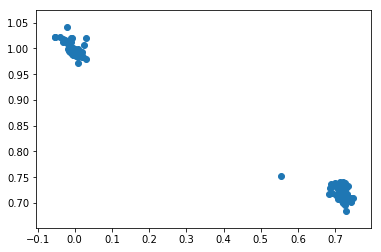

RUNNING
Epoch: 1501
RUNNING
Epoch: 1502
RUNNING
Epoch: 1503
RUNNING
Epoch: 1504
RUNNING
Epoch: 1505
RUNNING
Epoch: 1506
RUNNING
Epoch: 1507
RUNNING
Epoch: 1508
RUNNING
Epoch: 1509
RUNNING
Epoch: 1510
RUNNING
Epoch: 1511
RUNNING
Epoch: 1512
RUNNING
Epoch: 1513
RUNNING
Epoch: 1514
RUNNING
Epoch: 1515
RUNNING
Epoch: 1516
RUNNING
Epoch: 1517
RUNNING
Epoch: 1518
RUNNING
Epoch: 1519
RUNNING
Epoch: 1520
RUNNING
Epoch: 1521
RUNNING
Epoch: 1522
RUNNING
Epoch: 1523
RUNNING
Epoch: 1524
RUNNING
Epoch: 1525
RUNNING
Epoch: 1526
RUNNING
Epoch: 1527
RUNNING
Epoch: 1528
RUNNING
Epoch: 1529
RUNNING
Epoch: 1530
RUNNING
Epoch: 1531
RUNNING
Epoch: 1532
RUNNING
Epoch: 1533
RUNNING
Epoch: 1534
RUNNING
Epoch: 1535
RUNNING
Epoch: 1536
RUNNING
Epoch: 1537
RUNNING
Epoch: 1538
RUNNING
Epoch: 1539
RUNNING
Epoch: 1540
RUNNING
Epoch: 1541
RUNNING
Epoch: 1542
RUNNING
Epoch: 1543
RUNNING
Epoch: 1544
RUNNING
Epoch: 1545
RUNNING
Epoch: 1546
RUNNING
Epoch: 1547
RUNNING
Epoch: 1548
RUNNING
Epoch: 1549
RUNNING
Epoch: 1550


INFO:root:
binary training acc at epoch 1600: facc=0.875004
INFO:root:time: 24.954087
INFO:root:time: 24.963096


Epoch: 1600
epoch 1600
X: 

[-0.02599305]
<NDArray 1 @cpu(0)>
Y: 

[-0.00937116]
<NDArray 1 @cpu(0)>



[[-0.02599305  1.0018146 ]
 [-0.00937116  0.9943664 ]
 [-0.03204626  1.0053104 ]
 [-0.02371335  0.99148107]
 [ 0.70769465  0.6796792 ]
 [ 0.75657487  0.6715527 ]
 [-0.01986599  0.9901159 ]
 [ 0.69735706  0.6744067 ]
 [ 0.6659492   0.6917082 ]
 [ 0.69048536  0.69711965]
 [-0.02235538  0.9896995 ]
 [-0.00229388  0.989066  ]
 [-0.01200432  0.9928566 ]
 [ 0.6975559   0.6915539 ]
 [ 0.6962475   0.694825  ]
 [-0.00958949  0.99439883]
 [ 0.7163373   0.68172616]
 [-0.02265948  0.99092144]
 [ 0.7012691   0.6911377 ]
 [-0.01674205  0.9963033 ]
 [ 0.69009215  0.68697035]
 [-0.02602923  0.9977946 ]
 [ 0.08518818  0.93773216]
 [ 0.6790072   0.6848925 ]
 [-0.01877022  0.99464667]
 [ 0.00814193  0.9856764 ]
 [ 0.704311    0.68844736]
 [ 0.6794577   0.7000575 ]
 [-0.01229942  0.9964504 ]
 [ 0.677395    0.67891526]
 [-0.00831926  0.98942333]
 [ 0.67827135  0.6789019 ]
 [-0.03319001  0.989864  ]
 [-0.

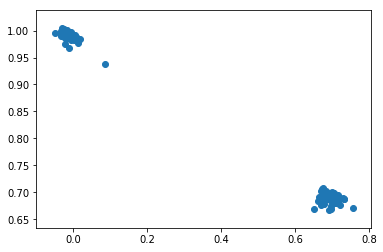

RUNNING
Epoch: 1601
RUNNING
Epoch: 1602
RUNNING
Epoch: 1603
RUNNING
Epoch: 1604
RUNNING
Epoch: 1605
RUNNING
Epoch: 1606
RUNNING
Epoch: 1607
RUNNING
Epoch: 1608
RUNNING
Epoch: 1609
RUNNING
Epoch: 1610
RUNNING
Epoch: 1611
RUNNING
Epoch: 1612
RUNNING
Epoch: 1613
RUNNING
Epoch: 1614
RUNNING
Epoch: 1615
RUNNING
Epoch: 1616
RUNNING
Epoch: 1617
RUNNING
Epoch: 1618
RUNNING
Epoch: 1619
RUNNING
Epoch: 1620
RUNNING
Epoch: 1621
RUNNING
Epoch: 1622
RUNNING
Epoch: 1623
RUNNING
Epoch: 1624
RUNNING
Epoch: 1625
RUNNING
Epoch: 1626
RUNNING
Epoch: 1627
RUNNING
Epoch: 1628
RUNNING
Epoch: 1629
RUNNING
Epoch: 1630
RUNNING
Epoch: 1631
RUNNING
Epoch: 1632
RUNNING
Epoch: 1633
RUNNING
Epoch: 1634
RUNNING
Epoch: 1635
RUNNING
Epoch: 1636
RUNNING
Epoch: 1637
RUNNING
Epoch: 1638
RUNNING
Epoch: 1639
RUNNING
Epoch: 1640
RUNNING
Epoch: 1641
RUNNING
Epoch: 1642
RUNNING
Epoch: 1643
RUNNING
Epoch: 1644
RUNNING
Epoch: 1645
RUNNING
Epoch: 1646
RUNNING
Epoch: 1647
RUNNING
Epoch: 1648
RUNNING
Epoch: 1649
RUNNING
Epoch: 1650


INFO:root:
binary training acc at epoch 1700: facc=0.875004
INFO:root:time: 24.920190
INFO:root:time: 24.923143


Epoch: 1700
epoch 1700
X: 

[0.69762313]
<NDArray 1 @cpu(0)>
Y: 

[-0.00506312]
<NDArray 1 @cpu(0)>



[[ 6.9762313e-01  7.0304555e-01]
 [-5.0631166e-03  9.7237986e-01]
 [ 7.3710448e-01  6.9846940e-01]
 [-2.7902007e-02  9.7693020e-01]
 [ 7.2113693e-01  6.9617981e-01]
 [ 6.1400533e-03  9.8228753e-01]
 [-1.7381132e-02  9.7186375e-01]
 [ 6.9584823e-01  7.0677531e-01]
 [-2.6218235e-02  9.9344254e-01]
 [ 7.1204692e-01  7.0455039e-01]
 [ 7.2033823e-01  6.5853304e-01]
 [ 7.0985168e-01  7.1191490e-01]
 [ 6.9374496e-01  7.0856422e-01]
 [-1.5549660e-02  9.6592712e-01]
 [ 7.0420128e-01  7.0690638e-01]
 [-4.0102720e-02  9.7941977e-01]
 [ 7.3018825e-01  7.0036101e-01]
 [-3.8293779e-02  9.8464787e-01]
 [ 7.0103544e-01  7.0703483e-01]
 [ 7.0977372e-01  7.0777166e-01]
 [ 7.3566973e-01  6.9137186e-01]
 [-2.3739338e-03  9.7546458e-01]
 [ 7.0775115e-01  7.1223825e-01]
 [-3.9000452e-02  9.8134071e-01]
 [-1.3487518e-02  9.7315806e-01]
 [ 5.1225239e-01  7.4160939e-01]
 [ 7.2496319e-01  6.9850063e-01]
 [-5.7

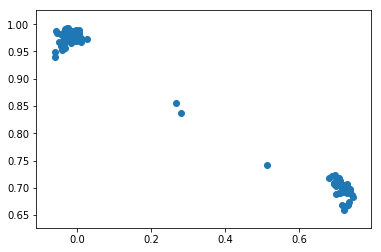

RUNNING
Epoch: 1701
RUNNING
Epoch: 1702
RUNNING
Epoch: 1703
RUNNING
Epoch: 1704
RUNNING
Epoch: 1705
RUNNING
Epoch: 1706
RUNNING
Epoch: 1707
RUNNING
Epoch: 1708
RUNNING
Epoch: 1709
RUNNING
Epoch: 1710
RUNNING
Epoch: 1711
RUNNING
Epoch: 1712
RUNNING
Epoch: 1713
RUNNING
Epoch: 1714
RUNNING
Epoch: 1715
RUNNING
Epoch: 1716
RUNNING
Epoch: 1717
RUNNING
Epoch: 1718
RUNNING
Epoch: 1719
RUNNING
Epoch: 1720
RUNNING
Epoch: 1721
RUNNING
Epoch: 1722
RUNNING
Epoch: 1723
RUNNING
Epoch: 1724
RUNNING
Epoch: 1725
RUNNING
Epoch: 1726
RUNNING
Epoch: 1727
RUNNING
Epoch: 1728
RUNNING
Epoch: 1729
RUNNING
Epoch: 1730
RUNNING
Epoch: 1731
RUNNING
Epoch: 1732
RUNNING
Epoch: 1733
RUNNING
Epoch: 1734
RUNNING
Epoch: 1735
RUNNING
Epoch: 1736
RUNNING
Epoch: 1737
RUNNING
Epoch: 1738
RUNNING
Epoch: 1739
RUNNING
Epoch: 1740
RUNNING
Epoch: 1741
RUNNING
Epoch: 1742
RUNNING
Epoch: 1743
RUNNING
Epoch: 1744
RUNNING
Epoch: 1745
RUNNING
Epoch: 1746
RUNNING
Epoch: 1747
RUNNING
Epoch: 1748
RUNNING
Epoch: 1749
RUNNING
Epoch: 1750


In [ ]:
from datetime import datetime
import time
import logging

real_label = nd.ones((batch_size * 2,), ctx = ctx)
fake_label = nd.zeros((batch_size * 2,), ctx = ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred>0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)


stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)
print("Begin")


#set up Discriminator first

for i in range(250):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    #print("RUNNING")
    for batch1 , batch2 in pairwise(train_data):
        ############################
        # (1) Update D network: maximizemr jones ukulele log(D(x)) + log(1 - D(G(z)))
        ###########################

        data = (mx.ndarray.concat(batch1.data[0], batch2.data[0], dim = 0)).as_in_context(ctx)
        
        #print("THIS IS A CHECK")
        #print(data)
        #print(len(data))
        #print(len(data[0]))
        #print(len(data[0][0]))
        #print(len(batch1.data[0]))
        #print(len(batch1.data[0][0]))
        #print(len(batch1.data[0][0][0]))
        #print(len(batch2.data[0]))
        #print(len(batch2.data[0][0]))
        #print(len(batch2.data[0][0][0]))
        #print(data)
        
        
        latent_z1 = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 2), ctx=ctx)
        latent_z2 = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 2), ctx=ctx)

        with autograd.record():
            # train with real image
            output = netD(data).reshape((-1, 1))
            errD_real = loss(output, real_label)
            #print("This is the guess for real")
            #print(output)
            metric.update([real_label,], [output,])

            # train with fake image
            firstFake = netG(latent_z1)
            secondFake = netG(latent_z2)
            
            #only add if using dense
            firstFake = firstFake.reshape((128, 1, 2))
            secondFake = secondFake.reshape((128, 1, 2))
            
            fake = mx.ndarray.concat(firstFake, secondFake, dim = 0)
            #print("TESTING")
            #print(len(fake))
            output = netD(fake.detach()).reshape((-1, 1))
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(mx.ndarray.concat(batch1.data[0], batch2.data[0], dim = 0).shape[0])
    name, acc = metric.get()
    metric.reset()
    
print("Done setting up Discriminator")
for epoch in range(epochs):
    train_data.reset()
    tic = time.time()
    btic = time.time()
    iter = 0
    print("RUNNING")
    for batch1, batch2 in pairwise(train_data):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        data = (mx.ndarray.concat(batch1.data[0], batch2.data[0], dim = 0)).as_in_context(ctx)
        
        #print("THIS IS A CHECK")
        #print(data)
        #print(len(data))
        #print(len(data[0]))
        #print(len(data[0][0]))
        #print(len(batch1.data[0]))
        #print(len(batch1.data[0][0]))
        #print(len(batch1.data[0][0][0]))
        #print(len(batch2.data[0]))
        #print(len(batch2.data[0][0]))
        #print(len(batch2.data[0][0][0]))
        #print(data)
        
        
        latent_z1 = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)
        latent_z2 = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)

        with autograd.record():
            # train with real image
            #print("Real Data")
            #print(data)
            output = netD(data).reshape((-1, 1))
            #print("Output of Discriminator")
            #print(output)
            errD_real = loss(output, real_label)
            #print("This is the guess for real")
            #print(output)
            metric.update([real_label,], [output,])

            # train with fake image
            firstFake = netG(latent_z1)
            secondFake = netG(latent_z2)
            #print("testing 1")
            #print(firstFake)
            
            #only add if using dense
            #firstFake = firstFake.reshape((128, 1, 2))
            #secondFake = secondFake.reshape((128, 1, 2))  
            #print("testing 2")
            #print(firstFake)
            

            fake = mx.ndarray.concat(firstFake, secondFake, dim = 0)
            #print("TESTING")
            #print(len(fake))
            output = netD(fake.detach()).reshape((-1, 1))
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(data.shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake1 = netG(latent_z1)
            fake2 = netG(latent_z2)
            #print(fake1)
            #rint(fake1.T)
            #print(fake1.T[0])
           # print(fake1.T[0][1])
            
            
            #only add if using dense
            #fake1 = fake1.reshape((128, 1, 2))
            #fake2 = fake2.reshape((128, 1, 2))
            
            output = netD(mx.ndarray.concat(fake1, fake2, dim = 0)).reshape((-1, 1))
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(mx.ndarray.concat(batch1.data[0], batch2.data[0]).shape[0])

        # Print log infomation every ten batches
        if iter % 10 == 0:
            name, acc = metric.get()
            #logging.firstFake info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            #logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
            #         %(nd.mean(errD).asscalar(),
            #           nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    #logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    #logging.info('time: %f' % (time.time() - tic))

    #Visualize one generated image for each epoch
    fake_img = fake1[0]
    #print("testing")
    #print("Fake data")
    #print(fake1)
    ##print("fake data transposed")
    #print(fake1.T)
    #print(len(fake))0
    #print(len(fake[0]))
    #print(len(fake[0][0]))
    #print(fake)
    
    
    #test small print
    #print("epoch %d" % (epoch))
    #print("X: %s   Y: %s  " % (fake_img[0][0],fake_img[0][1]))
    #x= fake.T[0][0].asnumpy().tolist()
    #y = fake.T[1][0].asnumpy().tolist()
    #print("Plot")
    #plt.scatter(x,y)
    #plt.show()
    
    
    
    
    #real print
    print("Epoch: %d" % epoch)
    if(epoch%100 == 0):
        logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
        logging.info('time: %f' % (time.time() - tic))
        logging.info('time: %f' % (time.time() - tic))
        print("epoch %d" % (epoch))
        
        #For convolution?
        #print("X: %s   Y: %s  " % (fake_img[0][0],fake_img[0][1]))
        #x= fake1.T[0][0].asnumpy().tolist()
        #y = fake1.T[0][1].asnumpy().tolist()
        
        x = fake1.T[0].asnumpy().tolist()
        y = fake1.T[1].asnumpy().tolist()
        print("X: ")
        print(fake1.T[0][0])
        print("Y: ")
        print(fake1.T[0][1])
        print("")
        print("")
        print(fake1)

        print("Plot")
        plt.scatter(x,y)
        plt.show()   
    
    # visualize(fake_img)
    # plt.show()
